In [37]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected= True)
cf.go_offline();
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option("display.max_columns",None)


In [38]:
df=pd.read_csv("amazon.csv")

In [39]:
df.head(5)


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


In [41]:
import pandas as pd

def missing_value_analysis(df):
    na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_cols].isnull().sum().sort_values(ascending=True)
    r = (df[na_cols].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(r, 2)], axis=1, keys=["missing values", "ratio"])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataf(df, head=5, tail=5):
    print("SHAPE".center(82, "~"))
    print(f"ROWS: {df.shape[0]}")
    print(f"COLUMNS: {df.shape[1]}")
    print("TYPES".center(82, "~"))
    print(df.dtypes)
    print("MISSING VALUES".center(82, "~"))
    print(missing_value_analysis(df))
    print("DUPLICATED VALUES".center(82, "~"))
    print(df.duplicated().sum())
    print("QUANTILES".center(82, "~"))
    numeric_df = df.select_dtypes(include=['number'])
    print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# Example usage:
check_dataf(df)

    
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ROWS: 4915
COLUMNS: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Unnamed: 0                int64
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~MISSING VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              missing values  ratio
reviewerName               1   0.02
reviewText                 1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00   0.05    0.50         0.9

In [43]:
df= df.sort_values("wilson_lower_bound",ascending=False)
df.drop("Unnamed: 0", inplace=True,axis =1)
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,I have tested dozens of SDHC and micro-SDHC ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,NOTE: please read the last update (scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,"If your card gets hot enough to be painful, it...",09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,Sandisk announcement of the first 128GB micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [44]:
def check_c(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                               'classes': [dataframe[i].unique() for i in dataframe.columns]})
    
   
    nunique_df['n_classes'] = nunique_df['classes'].apply(len)
    nunique_df = nunique_df.sort_values('n_classes', ascending=False)
    nunique_df = nunique_df.reset_index(drop=True)
    nunique_df = nunique_df.drop(columns=['classes'])
    
    return nunique_df


check_c(df)



,Variable,n_classes
0,reviewText,4913
1,reviewerName,4595
2,reviewTime,690
3,day_diff,690
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


In [45]:

import plotly.graph_objects as go


constraints = ['#B34D22', '#EBE00C', '#1FEB0C', '#0C92EB', '#EB0CD5']

def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot',''),
                        specs=[[{"type": "xy"}, {"type": "domain"}]],
                        horizontal_spacing=0.5)
    
    fig.add_trace(go.Bar(
        y=df[column_name].value_counts().values.tolist(),
        x=[str(i) for i in df[column_name].value_counts().index],
        textfont=dict(size=14),
        text=df[column_name].value_counts().values.tolist(),
        showlegend=False,
        name=column_name,
        textposition='auto',
        marker=dict(color=constraints,
                    line=dict(color='#DBE6EC', width=1))),
        row=1, col=1
    )

    fig.add_trace(go.Pie(
        labels=df[column_name].value_counts().keys(),
        textfont=dict(size=18),
        values=df[column_name].value_counts().values,
        textposition='auto',
        showlegend=False,
        name=column_name,
        marker=dict(colors=constraints)),
        row=1, col=2
    )

    fig.update_layout(
        title={'text': column_name, 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
        template='plotly_white'
    )
    
    iplot(fig)




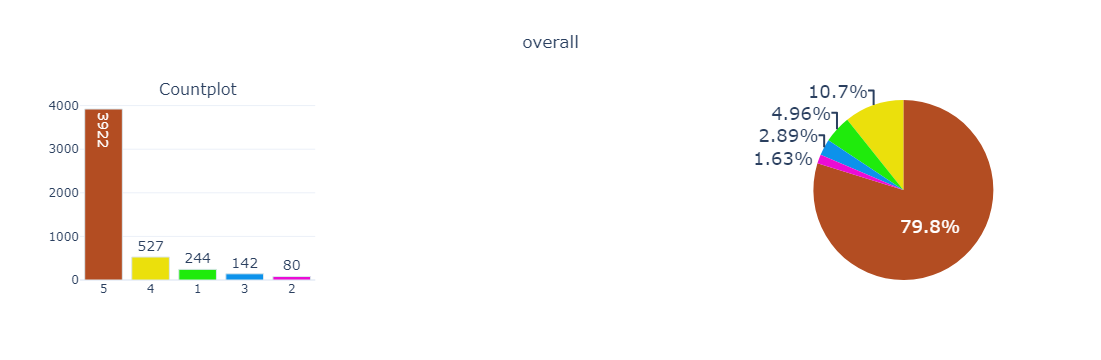

In [47]:
categorical_variable_summary(df, 'overall')

In [48]:
df.reviewText.head()

2031    [[ UPDATE - 6/19/2014 ]]So my lovely wife boug...
3449    I have tested dozens of SDHC and micro-SDHC ca...
4212    NOTE:  please read the last update (scroll to ...
317     If your card gets hot enough to be painful, it...
4672    Sandisk announcement of the first 128GB micro ...
Name: reviewText, dtype: object

In [49]:
review_example = df.reviewText[2031]
review_example

'[[ UPDATE - 6/19/2014 ]]So my lovely wife bought me a Samsung Galaxy Tab 4 for Father\'s Day and I\'ve been loving it ever since.  Just as other with Samsung products, the Galaxy Tab 4 has the ability to add a microSD card to expand the memory on the device.  Since it\'s been over a year, I decided to do some more research to see if SanDisk offered anything new.  As of 6/19/2014, their product lineup for microSD cards from worst to best (performance-wise) are the as follows:SanDiskSanDisk UltraSanDisk Ultra PLUSSanDisk ExtremeSanDisk Extreme PLUSSanDisk Extreme PRONow, the difference between all of these cards are simply the speed in which you can read/write data to the card.  Yes, the published rating of most all these cards (except the SanDisk regular) are Class 10/UHS-I but that\'s just a rating... Actual real world performance does get better with each model, but with faster cards come more expensive prices.  Since Amazon doesn\'t carry the Ultra PLUS model of microSD card, I had 

In [50]:
review_example = re.sub("[^a-zA-Z]",' ',review_example)
review_example

'   UPDATE               So my lovely wife bought me a Samsung Galaxy Tab   for Father s Day and I ve been loving it ever since   Just as other with Samsung products  the Galaxy Tab   has the ability to add a microSD card to expand the memory on the device   Since it s been over a year  I decided to do some more research to see if SanDisk offered anything new   As of            their product lineup for microSD cards from worst to best  performance wise  are the as follows SanDiskSanDisk UltraSanDisk Ultra PLUSSanDisk ExtremeSanDisk Extreme PLUSSanDisk Extreme PRONow  the difference between all of these cards are simply the speed in which you can read write data to the card   Yes  the published rating of most all these cards  except the SanDisk regular  are Class    UHS I but that s just a rating    Actual real world performance does get better with each model  but with faster cards come more expensive prices   Since Amazon doesn t carry the Ultra PLUS model of microSD card  I had to do

In [51]:
review_example = review_example.lower().split()
review_example

['update',
 'so',
 'my',
 'lovely',
 'wife',
 'bought',
 'me',
 'a',
 'samsung',
 'galaxy',
 'tab',
 'for',
 'father',
 's',
 'day',
 'and',
 'i',
 've',
 'been',
 'loving',
 'it',
 'ever',
 'since',
 'just',
 'as',
 'other',
 'with',
 'samsung',
 'products',
 'the',
 'galaxy',
 'tab',
 'has',
 'the',
 'ability',
 'to',
 'add',
 'a',
 'microsd',
 'card',
 'to',
 'expand',
 'the',
 'memory',
 'on',
 'the',
 'device',
 'since',
 'it',
 's',
 'been',
 'over',
 'a',
 'year',
 'i',
 'decided',
 'to',
 'do',
 'some',
 'more',
 'research',
 'to',
 'see',
 'if',
 'sandisk',
 'offered',
 'anything',
 'new',
 'as',
 'of',
 'their',
 'product',
 'lineup',
 'for',
 'microsd',
 'cards',
 'from',
 'worst',
 'to',
 'best',
 'performance',
 'wise',
 'are',
 'the',
 'as',
 'follows',
 'sandisksandisk',
 'ultrasandisk',
 'ultra',
 'plussandisk',
 'extremesandisk',
 'extreme',
 'plussandisk',
 'extreme',
 'pronow',
 'the',
 'difference',
 'between',
 'all',
 'of',
 'these',
 'cards',
 'are',
 'simply',
 

In [53]:
rt = lambda x: re.sub("[^a-zA-Z]",' ',str(x))
df["reviewText"] = df["reviewText"].map(rt)
df["reviewText"] = df["reviewText"].str.lower()
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


def get_sentiment_category(score):
    if score['compound'] >= 0.05:
        return "Positive"
    elif score['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"


df['sentiment_scores'] = df['reviewText'].apply(analyzer.polarity_scores)


df['sentiment'] = df['sentiment_scores'].apply(get_sentiment_category)


df.drop(columns=['sentiment_scores'], inplace=True)




In [56]:
df[df['sentiment'] == 'Positive'].sort_values('wilson_lower_bound',ascending = False).head(5)

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,sentiment
2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544,Positive
3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519,Positive
4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139,Positive
317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577,Positive
4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109,Positive


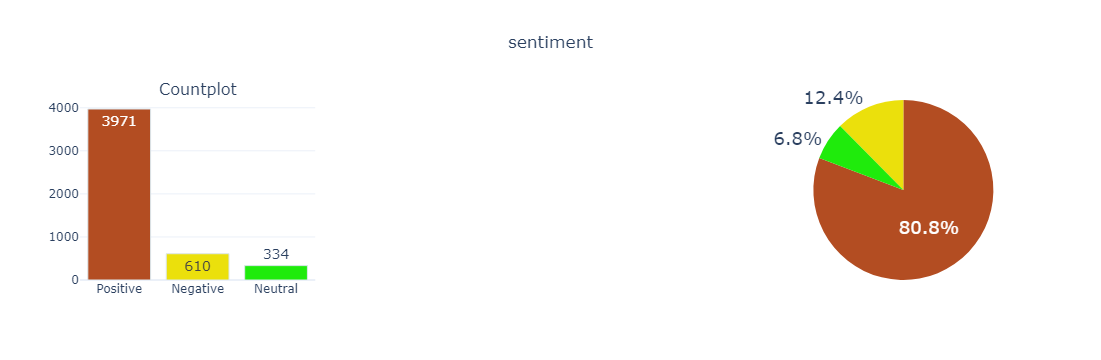

In [58]:
categorical_variable_summary(df,'sentiment')